# 허깅페이스로 커스템 프로젝트 만들기
## 한국어 데이터셋을 활용한 커스텀 프로젝트
-  model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task를 도전

### 목차
0. 라이브러리 버전 확인
1. NSMC 데이터 분석 및 Huggingface dataset 구성
  - [NCMS](https://github.com/e9t/nsmc)
2. klue/bert-base model 및 tokenizer 불러오기
  - [KLUE BERT](https://huggingface.co/klue/bert-base)
3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기
4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
  - 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 
5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교
  - bucketing
  - dynamic padding
6. 회고


### 0. 라이브러리 버전 확인


In [1]:
!nvidia-smi

Fri Sep 15 03:07:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


### STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성


In [3]:
import datasets
from datasets import load_dataset

data = load_dataset('nsmc')
data

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [4]:
train = data['train']
test = data['test']

train

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 150000
})

In [5]:
cols = train.column_names
for i in range(3):
    for col in cols:
        print(col, ":", train[col][i])
        print('\n')
    

id : 9976970


document : 아 더빙.. 진짜 짜증나네요 목소리


label : 0


id : 3819312


document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나


label : 1


id : 10265843


document : 너무재밓었다그래서보는것을추천한다


label : 0




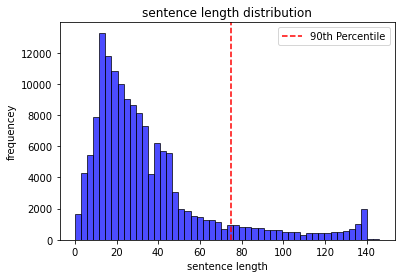

In [6]:
import matplotlib.pyplot as plt
import numpy as np
document_lengths = [len(example["document"]) for example in data["train"]]

# 히스토그램 그리기
plt.hist(document_lengths, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('sentence length')
plt.ylabel('frequencey')
plt.title('sentence length distribution')

# 데이터 정렬 후 백분위수 계산
sorted_lengths = np.sort(document_lengths)
percentile_90 = np.percentile(sorted_lengths, 90)

# 90% 백분위수에 해당하는 수직선 그리기
plt.axvline(x=percentile_90, color='red', linestyle='--', label='90th Percentile')
plt.legend()
plt.show()

sentence lenght가 80 이하일때도 전체 데이터셋의 90%를 남길 수 있으므로 max_legnth를 80으로 설정해야겠다

## 2. klue/bert-base model 및 tokenizer 불러오기


In [7]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base')
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [17]:
# 토크나이징 함수

def transform(data):
    return tokenizer(
        data['document'],
    truncation = True,
    padding='max_length')

##  3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기


In [9]:
!nvidia-smi

Fri Sep 15 03:07:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# 데이터셋 전처리
dataset = data.map(transform, batched=True)

train = dataset['train']
test = dataset['test']

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [19]:

# 데이터셋 분할 비율 설정
train_ratio = 0.8  # 예: 80%의 데이터를 train으로 사용
val_ratio = 0.2    # 예: 20%의 데이터를 val로 사용

# 데이터셋을 train과 val로 분할
num_samples = len(dataset['train'])  # 전체 데이터셋의 샘플 수
num_train_samples = int(num_samples * train_ratio)
num_val_samples = num_samples - num_train_samples

# 데이터셋 분할
train_dataset = train.select(range(num_train_samples))
val_dataset = train.select(range(num_train_samples, num_samples))
test_dataset = test

In [20]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fri Sep 15 03:08:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/

In [21]:
# 모델 학습
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
# compute metrics: trainer의 인자
from datasets import load_metric
metric = load_metric('glue', 'sst2')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [24]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 120000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.266500,0.293891,0.904267


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoi

TrainOutput(global_step=15000, training_loss=0.31742907206217447, metrics={'train_runtime': 12290.1012, 'train_samples_per_second': 9.764, 'train_steps_per_second': 1.22, 'total_flos': 3.15733266432e+16, 'train_loss': 0.31742907206217447, 'epoch': 1.0})

In [31]:
import json
# 모델 및 학습 설정 저장
model.save_pretrained("saved_model_directory")
training_args_dict = training_arguments.to_dict()  # 설정을 딕셔너리로 변환
with open("training_args.json", "w") as training_args_file:
    json.dump(training_args_dict, training_args_file)


Configuration saved in saved_model_directory/config.json
Model weights saved in saved_model_directory/pytorch_model.bin


In [ ]:
# 모델 및 학습 설정 불러오기
loaded_model = BertForTokenClassification.from_pretrained("saved_model_directory")
loaded_training_args_dict = json.load(open("training_args.json", "r"))  # 설정 불러오기
loaded_training_args = TrainingArguments.from_dict(loaded_training_args_dict)

In [25]:
trainer.evaluate(test_dataset)


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 8


KeyboardInterrupt: 

In [ ]:
#del trainer
#torch.cuda.empty_cache()  # GPU 메모리 해제


## 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
  - 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 



In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

new_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base')


In [ ]:
# 가중치 감소 0.1 > 0.001. 과적합 줄이는 데 도움
new_training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate(2e-5~5e-5)
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.001,                        # weight decay(0,1, 0.01)
)

In [ ]:
new_trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
new_trainer.train()

In [ ]:
#del trainer
#torch.cuda.empty_cache()  # GPU 메모리 해제


## 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

bucketing과 dynamic padding은 자연어 처리 모델에서 시퀸스 데이터를 효율적으로 처리하기 위한 기술이다

### bucketing
- 입력 시퀸스의 길이에 따라 데이터를 그룹화하거나 버킷으로 나누는 기술
- 각 버킷에는 유사한 길이의 시퀸스가 포함된다
- gpu를 효율적으로 사용할 수 있으나 적절한 버킷 크기와 수를 선택하는 것이 중요하다.

### dynamic padding
- 각 시퀸스의 길이에 따라 패딩을 추가한다
- 길이가 가장 긴 시퀸스를 기준으로 다른 시퀸스들에 패딩을 추가하여 모든 시퀸스를 동일한 길이로 만든다.

In [ ]:
from transformers import BertTokenizer, DataCollatorForTokenClassification

# KLUE BERT 모델 및 토크나이저 로드
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model3 = AutoModelForSequenceClassification.from_pretrained('klue/bert-base')

data_collator = DataCollatorForTokenClassification(tokenizer)


# DataLoader 설정 (bucketing 및 dynamic padding 적용)
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=data_collator,
    batch_size=16,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset,
    collate_fn=data_collator,
    batch_size=16,
    shuffle=False,
)


In [ ]:
training_args3 = TrainingArguments(
    output_dir="./bert_nsmc",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,  # 학습할 epoch 수
    load_best_model_at_end=True,
)

In [ ]:
# Trainer 초기화
trainer3 = Trainer(
    model=model3,
    args=training_args3,
    train_dataset=train_dataloader.dataset,
    eval_dataset=val_dataloader.dataset,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.predictions.argmax(axis=2).flatten(), p.label_ids.flatten())},
)


In [ ]:
# 모델 학습
trainer3.train()


In [ ]:
# 테스트 데이터셋 평가
results = trainer.evaluate(test_dataset)


In [ ]:
print("Test Accuracy:", results["eval_accuracy"])


## 6. 회고
- 지난 노드부터 자꾸 메모리 부족 문제가 나서 힘들었다. 메모리 관리 잘하기
- 데이터셋 한 sample을 돌리는 법을 모르겠다. documentation을 보자
- 모델 학습에 시간이 오래 걸린다.